# Modelo para dados do Punk API

<a href="https://colab.research.google.com/github/ggarciabas/mlops_aws_punkapi/blob/analise/notebooks/Modelagem.ipynb" target="_parent"><img src="https://img.shields.io/badge/Colab-Google?style=for-the-badge&labelColor=white&color=orange&logo=googlecolab" alt="Open In Colab"/></a>

In [ ]:
! pip install --upgrade pandas pandas_profiling vtreat biokit xgboost
# atualiza pacotes para compatibilidade pandas e Pprofiling, instala vtreat

## Leitura dos dados iniciais

In [89]:
import requests
import json
import pandas as pd

In [3]:
# Schema definido pela Tabela Glue
tipo_schema = {'id': 'int', 
                'name': 'str', 
                'abv': 'double', 
                'ibu': 'int',
                'target_fg': 'int',
                'target_og': 'int',
                'ebc': 'double',
                'srm': 'double',
                'ph': 'double',
                'ebc_color':'int',
                'srm_color':'int'
               }

In [70]:
# Cria Dataframe inicial para armazenar as bebidas
url='https://drive.google.com/file/d/1FPcnS0vh0SGBRDdkiGDZCc3l_nx2zC1K/view?usp=sharing' # amostra 1000/1500 ibus
url2='https://drive.google.com/uc?export=download&id=' + url.split('/')[-2]
# https://stackoverflow.com/questions/56611698/pandas-how-to-read-csv-file-from-google-drive-public
pd_beers = pd.read_json(url2)

In [71]:
pd_beers[:2]

id  ...          contributed_by
0   49  ...  Sam Mason <samjbmason>
1  158  ...  Sam Mason <samjbmason>

[2 rows x 21 columns]

In [72]:
pd_beers.dtypes

id                     int64
name                  object
tagline               object
first_brewed          object
description           object
image_url             object
abv                  float64
ibu                  float64
target_fg            float64
target_og            float64
ebc                  float64
srm                  float64
ph                   float64
attenuation_level    float64
volume                object
boil_volume           object
method                object
ingredients           object
food_pairing          object
brewers_tips          object
contributed_by        object
dtype: object

In [73]:
pd_beers.count()

id                   2500
name                 2500
tagline              2500
first_brewed         2500
description          2500
image_url            2056
abv                  2500
ibu                  2477
target_fg            2495
target_og            2495
ebc                  2452
srm                  2452
ph                   2486
attenuation_level    2495
volume               2500
boil_volume          2500
method               2500
ingredients          2500
food_pairing         2500
brewers_tips         2500
contributed_by       2500
dtype: int64

## Limpa e organiza base para análises

- International Bitterness Unit (IBU): potencial de amargor
- Alcohol By Volume (ABV): porcentagem de álcool
  > $𝐴𝐵𝑉=(𝑂𝐺−𝐹𝐺)∗131,25$
  - Original Gravity (OG): densidade antes do processo
  - Final Gravity (FG): densidado após proceddo
- Standard Reference Method (SRM): coloração
- European Brewery Convention (EBC): coloração
- pH da água

In [74]:
features = ['abv', 'target_fg', 'target_og', 'ebc', 'srm', 'ph']
target = 'ibu'
cols = features+[target]

In [75]:
pd_beers_clean = pd_beers[cols].drop_duplicates().reindex()

In [76]:
# A métrica é relacionada à àgua (> 1000)
# pd_beers_clean['target_fg'] = pd_beers_clean['target_fg']-1000
# pd_beers_clean['target_og'] = pd_beers_clean['target_og']-1000

In [77]:
pd_beers_clean[target].notna().sum()
# Mesmo solicitando a API registros com IBU válido!

283

In [78]:
# remove informações sem dados na coluna target
pd_beers_clean = pd_beers_clean[pd_beers_clean[target].notna()]

In [79]:
# Ceveja clara ou escura
# pd_beers_clean['ebc_color'] = pd_beers_clean['ebc'].apply(lambda x: (1 if x<20 else 0) if x else -1)
# pd_beers_clean['srm_color'] = pd_beers_clean['srm'].apply(lambda x: (1 if x<12 else 0)  if x else -1 )

In [80]:
pd_beers_clean[:4]

abv  target_fg  target_og   ebc   srm   ph    ibu
0  10.0     1016.0     1094.0  20.0  10.0  4.4   30.0
1   6.4     1012.0     1061.0  20.0  10.0  4.4   50.0
2   9.2     1085.0     1016.0  78.8  40.0  4.2   50.0
3   9.7     1015.0     1088.0  30.0  15.3  4.4  100.0

In [81]:
pd_beers_clean.count()

abv          283
target_fg    283
target_og    283
ebc          279
srm          279
ph           282
ibu          283
dtype: int64

In [82]:
pd_beers_clean.columns

Index(['abv', 'target_fg', 'target_og', 'ebc', 'srm', 'ph', 'ibu'], dtype='object')

In [83]:
pd_beers_clean.max() - pd_beers_clean.min()

abv            40.5
target_fg     125.0
target_og     150.0
ebc           598.0
srm           304.0
ph             75.8
ibu          1157.0
dtype: float64

In [84]:
len(pd_beers_clean['ibu'].unique())

53

In [85]:
pd_beers_clean.groupby("ibu").ibu.count()
# what?! só regressão..

ibu
0.0        1
5.0        1
8.0        8
9.0        1
10.0       1
14.0       1
15.0       2
17.0       1
18.0       1
20.0      12
20.5       1
22.0       2
25.0      14
26.0       1
28.0       1
30.0      15
32.0       3
33.0       1
34.0       1
35.0      22
36.0       1
37.0       4
38.0       2
40.0      19
41.5       1
42.0       3
45.0      10
47.0       1
50.0      27
52.0       1
55.0      12
59.0       1
60.0      11
65.0      11
67.0       2
68.0       1
70.0      23
75.0       5
77.0       1
80.0      12
85.0      13
90.0       3
100.0     14
125.0      2
130.0      2
132.0      1
149.0      1
150.0      1
175.0      1
198.0      1
250.0      4
1085.0     1
1157.0     1
Name: ibu, dtype: int64

### Distribuição dos valores

[Pandas profiling](https://pandas-profiling.github.io/pandas-profiling/docs/master/rtd/)






In [86]:
from pandas_profiling import ProfileReport

In [87]:
def plot_profile (pdf):
  return ProfileReport(pdf)

In [88]:
plot_profile(pd_beers_clean[cols])

Summarize dataset:   0%|          | 0/21 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

> Variáveis com alta correlação EBC e SRM.

- IBU possui 53 valores distintos. 
- 50% dos dados estão entre 35 e 70.
- Valor mínimo é zero e máximo 1157.

### Correlação



In [90]:
from biokit.viz import corrplot

Creating directory /root/.config/biokit 
Creating directory /root/.config/bioservices 


In [91]:
def plot_correlacao (pdf):
  df_corr = pdf.corr()
  c = corrplot.Corrplot(df_corr)
  c.plot(colorbar=False, method='square', shrink=.9 ,rotation=45)

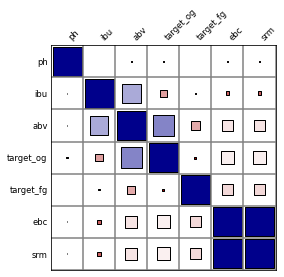

In [92]:
plot_correlacao(pd_beers_clean)

> IBU apresenta uma correlação boa com ABV.

- Remover EBC ou SRM
- Remover ebc_color ou srm_color
> Alta correlação entre as informações (redundância)



## Machine Learning Model

1. [Machine learning: classification and regression](https://training.galaxyproject.org/training-material/topics/statistics/tutorials/classification_regression/tutorial.html#regression)
1. [Regression Metrics for Machine Learning](https://machinelearningmastery.com/regression-metrics-for-machine-learning/)
1. [Os Três Tipos de Aprendizado de Máquina](https://lamfo-unb.github.io/2017/07/27/tres-tipos-am/)
1. [Um Olhar Descontraído Sobre o Dilema Viés-Variância](https://lamfo-unb.github.io/2017/04/29/Um-Olhar-Descontraido-Sobre-o-Dilema-Vies-Variancia/)
1. [Regressão Logística](https://lamfo-unb.github.io/2020/04/30/Regress%C3%A3o-Log%C3%ADstica/)
1. [Why Data Normalization is necessary for Machine Learning models](https://medium.com/@urvashilluniya/why-data-normalization-is-necessary-for-machine-learning-models-681b65a05029)
1. [Model Tuning (Part 1 - Train/Test Split)](https://dziganto.github.io/data%20science/machine%20learning/model%20tuning/python/Model-Tuning-Train-Test-Split/)
1. [What is Regression? | SSE, SSR, SST | R-squared | Errors (ε vs. e)](https://www.youtube.com/watch?v=aq8VU5KLmkY)
1. [Regression II - Degrees of Freedom EXPLAINED | Adjusted R-Squared](https://www.youtube.com/watch?v=4otEcA3gjLk)
1. [Model Tuning (Part 2 - Validation & Cross-Validation)](https://dziganto.github.io/cross-validation/data%20science/machine%20learning/model%20tuning/python/Model-Tuning-with-Validation-and-Cross-Validation/)

In [109]:
from sklearn import model_selection, preprocessing, linear_model, metrics
import numpy as np

### Regressão anotações



> Regression predictive modeling is the task of approximating a mapping function (f) from input variables (X) to a continuous output variable (y). [2]

> The skill or performance of a regression model must be reported as an error in those predictions. [2]

**Metricas**
- Mean Squared Error (MSE).
  > $MSE =  \frac{\sum_{i}ˆN \left(y_i – yˆ_i\right)^2}{N}$\
  > A raiz remove o sinal da diferença e também infla as diferenças grandes.\
  > Como função de perda o MSE pune o modelo por grandes diferenças.\
  > Como métrica esta pune o modelo inflando o score do erro.
- Root Mean Squared Error (RMSE).
- Mean Absolute Error (MAE)
- Others [Sklearn Regression metrics](https://scikit-learn.org/stable/modules/classes.html#regression-metrics)


[XGBoost for Regression](https://machinelearningmastery.com/xgboost-for-regression/)
  - Execution speed and model performance.
  > XGBoost became the go-to method.\
  > Gradient boosting refers to a class of ensemble machine learning algorithms that can be used for classification or regression predictive modeling problems.\
  > Ensembles are constructed from decision tree models. Trees are added one at a time to the ensemble and fit to correct the prediction errors made by prior models. This is a type of ensemble machine learning model referred to as boosting.

### Dados para modelo

In [98]:
b_feat = ['abv', 'target_fg', 'target_og', 'ebc', 'ph', 'srm'] 
b_target = 'ibu'
b_cols = b_feat+[b_target]
b_schema = {k:tipo_schema[k] for k in b_cols}

In [103]:
baseline = pd_beers_clean[b_cols]

#### Nulos

In [100]:
baseline.mean()

abv             7.761837
target_fg    1015.409894
target_og    1067.459011
ebc            70.429749
ph              4.684752
srm            35.495054
ibu            63.583039
dtype: float64

In [101]:
baseline = baseline.fillna(baseline.mean()) # utilizado pelo v-treat

#### Schema

In [102]:
baseline = baseline.astype(dtype=b_schema)
baseline.dtypes

abv          float64
target_fg      int64
target_og      int64
ebc          float64
ph           float64
srm          float64
ibu            int64
dtype: object

#### Treino e Teste

In [92]:
from sklearn.model_selection import train_test_split

In [93]:
B_train, B_test = train_test_split(baseline, test_size=0.33, random_state=42) # 67//33

### Avalia Modelos

#### Funções

In [104]:
# Evaluation method
def evaluate_mae_model (model, X, y):
  cv_sc = 'neg_mean_absolute_error'
  cv = model_selection.RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = model_selection.cross_val_score(model, X, y, scoring=cv_sc, cv=cv, n_jobs=-1)
  scores = np.absolute(scores)
  print(f"Mean MAE: {scores.mean()} ({scores.std()})") # mean absolute error

In [105]:
def evaluate_r2_model (model, X, y):
  cv_sc = 'r2'
  cv = model_selection.RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = model_selection.cross_val_score(model, X, y, scoring=cv_sc, cv=cv, n_jobs=-1)
  print(f"R^2: {scores.mean()} ({scores.std()})") # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score

In [106]:
def evaluate_rmse_model (model, X, y):
  cv_sc = 'neg_root_mean_squared_error'
  cv = model_selection.RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = model_selection.cross_val_score(model, X, y, scoring=cv_sc, cv=cv, n_jobs=-1)
  print(f"RMSE: {scores.mean()} ({scores.std()})") # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score

In [107]:
def calc_r2_rmse(X, y, model):
    '''returns the R^2 and RMSE; assumes model already fit.'''
    predictions = model.predict(X)
    mse = metrics.mean_squared_error(y, predictions)
    rmse = np.sqrt(mse)
    return model.score(X, y), rmse
# Ref: https://dziganto.github.io/data%20science/machine%20learning/model%20tuning/python/Model-Tuning-Train-Test-Split/

#### Baseline

##### Regressão linear

In [110]:
lr = linear_model.LinearRegression(fit_intercept=True)
# Scores
evaluate_r2_model(lr, baseline[b_feat], baseline[b_target])
evaluate_rmse_model(lr, baseline[b_feat], baseline[b_target])
evaluate_mae_model(lr, baseline[b_feat], baseline[b_target])

R^2: nan (nan)
RMSE: nan (nan)
Mean MAE: nan (nan)


In [160]:
lr = linear_model.LinearRegression(fit_intercept=True)
lr.fit(B_train[b_feat], B_train[b_target])

# ISE
print ("ISE")
r2_t, rmse_t = calc_r2_rmse(B_train[b_feat], B_train[b_target], lr)
print ("\tR^2 %.3f \tRMSE %.3f " % (r2_t, rmse_t))

# OSE
print ("OSE")
r2_v, rmse_v = calc_r2_rmse(B_test[b_feat], B_test[b_target], lr)
print ("\tR^2 %.3f \tRMSE %.3f " % (r2_v, rmse_v))

print (f"\nTest/Train {rmse_v/rmse_t} -> {((rmse_v/rmse_t)-1)*100} %")

ISE
	R^2 0.673 	RMSE 65.685 
OSE
	R^2 -3.578 	RMSE 87.488 

Test/Train 1.3319217898576001 -> 33.19217898576001 %


##### XGBoost

In [40]:
import xgboost
print(xgboost.__version__)

1.4.2


In [ ]:
xgb = xgboost.XGBRegressor()

###### MAE

In [77]:
# original
evaluate_mae_model(xgb, baseline[b_feat], baseline[b_target]) # MAE
# normalizado
evaluate_mae_model(xgb, B_norm[b_feat], B_norm[b_target]) # MAE

Mean MAE: 23.1389619943984 (4.656110344295017)
Mean MAE: 0.23869709349937995 (0.04759670132047508)


###### MSE

In [78]:
evaluate_mae_model(xgb, baseline[b_feat], baseline[b_target], score='mean_squared_error') # MSE
evaluate_mae_model(xgb, B_norm[b_feat], B_norm[b_target], score='mean_squared_error') # MSE

Mean mean_squared_error: 23.1389619943984 (4.656110344295017)
Mean mean_squared_error: 0.23869709349937995 (0.04759670132047508)


##### ADA Boost

In [63]:
from sklearn.ensemble import AdaBoostRegressor

In [64]:
ada = AdaBoostRegressor()
# original
evaluate_mae_model(ada, baseline[b_feat], baseline[b_target])
evaluate_mae_model(ada, B_norm[b_feat], B_norm[b_target])

Mean MAE: 29.548 (15.622)
Mean MAE: 0.286 (0.153)


---------

#### Normalização

In [89]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
def normaliza_dados (data):
  std_scale = preprocessing.StandardScaler().fit(data) # Standardize features by removing the mean and scaling to unit variance (z = (x - u) / s)
  return pd.DataFrame(std_scale.transform(data), columns=data.columns)

In [90]:
# normaliza
baseline_norm = normaliza_dados(baseline)

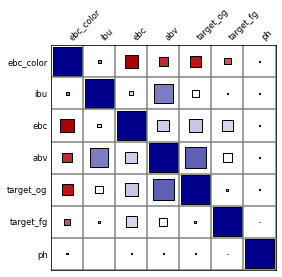

In [91]:
plot_correlacao(baseline_norm)

### V-treat

[Using vtreat with Regression Problems](https://github.com/WinVector/pyvtreat/blob/master/Examples/Regression/Regression.md)

In [ ]:
import vtreat

In [ ]:
transform = vtreat.NumericOutcomeTreatment(outcome_name=target) 

In [ ]:
pd_vtreat = transform.fit_transform(pd_beers_clean, pd_beers_clean[target])

Score frame, which gives information about each new variable, including its type, which original variable it is derived from, its (cross-validated) correlation with the outcome, and its (cross-validated) significance as a one-variable linear model for the outcome.

In [ ]:
transform.score_frame_

variable orig_variable  ... default_threshold  recommended
0    ph_is_bad            ph  ...          0.166667        False
1   ebc_is_bad           ebc  ...          0.166667        False
2   srm_is_bad           srm  ...          0.166667        False
3           ph            ph  ...          0.062500        False
4          ebc           ebc  ...          0.062500         True
5    target_fg     target_fg  ...          0.062500        False
6    srm_color     srm_color  ...          0.062500         True
7    ebc_color     ebc_color  ...          0.062500        False
8          abv           abv  ...          0.062500         True
9    target_og     target_og  ...          0.062500         True
10         srm           srm  ...          0.062500         True

[11 rows x 11 columns]

In [ ]:
pd_vtreat[:2]

ibu   ebc  srm_color   abv  target_og   srm
0  30.0  20.0        1.0  10.0       94.0  10.0
1  50.0  20.0        1.0   6.4       61.0  10.0

In [ ]:
pd_vtreat.isna().all()

ibu          False
ebc          False
srm_color    False
abv          False
target_og    False
srm          False
dtype: bool

#### Como tratou nulos (média)

In [ ]:
pd_beers_clean.isna().columns

Index(['abv', 'target_fg', 'target_og', 'ebc', 'srm', 'ph', 'ibu', 'ebc_color',
       'srm_color'],
      dtype='object')

In [ ]:
print (pd_beers_clean['ebc'].mean())
pd_vtreat['ebc'][list(pd_beers_clean['ebc'].isna())] # consulta o que o vtreat fez com os nulos

70.3953237410072


24     70.395324
45     70.395324
49     70.395324
117    70.395324
Name: ebc, dtype: float64

In [ ]:
print(pd_beers_clean['srm'].mean())
pd_vtreat['srm'][list(pd_beers_clean['srm'].isna())] # consulta o que o vtreat fez com os nulos

35.47525179856117


24     35.475252
45     35.475252
49     35.475252
117    35.475252
Name: srm, dtype: float64

In [ ]:
print(pd_beers_clean['srm'].mean())
pd_vtreat['srm'][list(pd_beers_clean['srm'].isna())] # consulta o que o vtreat fez com os nulos

35.47525179856117


24     35.475252
45     35.475252
49     35.475252
117    35.475252
Name: srm, dtype: float64